## Contents
* [1. Baseline Model](#1.-Baseline-Model)
* [2. Imports](#2.-Imports)
* [3. Data Cleaning & Preparation](#3.-Data-Cleaning-&-Preparation)
* [4. Model Fit & Predict](#4.-Model-Fit-&-Predict)
    * [4.1 Baseline 1 (w/o Lemm/Stem)](#4.1-Baseline-1-(w/o-Lemm/Stem))
    * [4.2 Baseline 2 (with Lemm)](#4.2-Baseline-2-(with-Lemm))
    * [4.3 Baseline 3 (with Stem)](#4.3-Baseline-3-(with-Stem))
* [5. Remarks](#5.-Remarks)

---
## 1. Baseline Model
---
Aim: to develop a baseline multi-class model using CountVectoriser and Multinomial Naive Bayes model, and to compare the effects of lemmatization, stemming and without both.

|                           | Baseline 1              | Baseline 2                 | Baseline 3                 |
|---------------------------|-------------------------|----------------------------|----------------------------|
| Pre-processing            | - Basic cleaning          | - basic cleaning<br>- lemm | - basic cleaning<br>- stem |
| Vectoriser                | CountVectoriser         | CountVectoriser            | CountVectoriser            |
| Model                     | Multinomial Naive Bayes | Multinomial Naive Bayes    | Multinomial Naive Bayes    |

Note: the code below was ran on Kaggle, to make use of Kaggle GPUs.

---
## 2. Imports
---

In [85]:
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, roc_auc_score, f1_score

---
## 3. Data Cleaning & Preparation
---
- Read extracted KrisFlyer, lounge, catering, amenity kits' data
- to put together a dataframe of comments and thread titles for model. Using comments for their wealth of words, and titles for their highlighting of key words

In [86]:
kf_comments_df = pd.read_csv('/kaggle/input/sq-services/KrisFlyer_comments.csv')
kf_titles_df = pd.read_csv('/kaggle/input/sq-services/KrisFlyer_URLs.csv')

# (L)ounge, (C)atering, (A)menity kits
LCA_comments_df = pd.read_csv('/kaggle/input/sq-services/lounge_amenities_comments.csv')
LCA_titles_df = pd.read_csv('/kaggle/input/sq-services/lounge_amenities_URLs.csv')

other_comments_df = pd.read_csv('/kaggle/input/sq-services/other_comments.csv')
other_titles_df = pd.read_csv('/kaggle/input/sq-services/other_URLs.csv')

print(kf_comments_df.head())
print(kf_titles_df.head())

                                            comments
0  Hi Guys,I'm still DAMN confused after reading ...
1  ah relax. you can be the perfect test case the...
2  There's no need to panic. Been in a similar si...
3  Originally posted by Nick CView PostThere's no...
4  Firstly, Welcome to SQTalk, Vtac82!Krisflyer m...
                                          title  \
0           Qualifying as EG for the first time   
1           Which FFP for me? Master Discussion   
2                              #SQMelbourneTram   
3  Advice sought - Changing redemption bookings   
4                          First Savers SYD-SIN   

                                                 url  
0  http://www.sqtalk.com/forum/forum/singapore-ai...  
1  http://www.sqtalk.com/forum/forum/singapore-ai...  
2  http://www.sqtalk.com/forum/forum/singapore-ai...  
3  http://www.sqtalk.com/forum/forum/singapore-ai...  
4  http://www.sqtalk.com/forum/forum/singapore-ai...  


- drop off the url column as it is redundant for NLP

In [87]:
kf_titles_df.drop(columns='url',inplace=True)
LCA_titles_df.drop(columns='url',inplace=True)
other_titles_df.drop(columns='url',inplace=True)

- adding a 'source' column to each df to indicate which forum is the data from
- this 'source' column will be used as the target variable later

In [88]:
kf_comments_df['source'] = 'kf'
kf_titles_df['source'] = 'kf'
LCA_comments_df['source'] = 'lca'
LCA_titles_df['source'] = 'lca'
other_comments_df['source'] = 'other'
other_titles_df['source'] = 'other'

kf_comments_df.head()

,comments,source
0,"Hi Guys,I'm still DAMN confused after reading ...",kf
1,ah relax. you can be the perfect test case the...,kf
2,There's no need to panic. Been in a similar si...,kf
3,Originally posted by Nick CView PostThere's no...,kf
4,"Firstly, Welcome to SQTalk, Vtac82!Krisflyer m...",kf


- aligning 'comments' and 'title' columns to the same name 'text'

In [89]:
kf_comments_df.rename(columns={'comments':'text'}, inplace=True)
kf_titles_df.rename(columns={'title':'text'}, inplace=True)
LCA_comments_df.rename(columns={'comments':'text'}, inplace=True)
LCA_titles_df.rename(columns={'title':'text'}, inplace=True)
other_comments_df.rename(columns={'comments':'text'}, inplace=True)
other_titles_df.rename(columns={'title':'text'}, inplace=True)

kf_comments_df.head()

,text,source
0,"Hi Guys,I'm still DAMN confused after reading ...",kf
1,ah relax. you can be the perfect test case the...,kf
2,There's no need to panic. Been in a similar si...,kf
3,Originally posted by Nick CView PostThere's no...,kf
4,"Firstly, Welcome to SQTalk, Vtac82!Krisflyer m...",kf


- export cleaned datasets

In [90]:
kf_df = pd.concat([kf_titles_df, kf_comments_df])
LCA_df = pd.concat([LCA_titles_df, LCA_comments_df])
other_df = pd.concat([other_titles_df, other_comments_df])

kf_df.to_csv('/kaggle/working/kf_clean.csv', index=False)
LCA_df.to_csv('/kaggle/working/LCA_clean.csv', index=False)
other_df.to_csv('/kaggle/working/other_clean.csv', index=False)

- concatenate kf and LCA's titles and comments into one df

In [91]:
services_df = pd.concat([kf_df, LCA_df, other_df])
services_df.shape

(44130, 2)

- check for and resolve any NA values

In [92]:
print(services_df.isna().sum())

# acceptable to drop 3 NA values out of 44k values
services_df.dropna(inplace=True)
# reset index, and drop old index
services_df.reset_index(drop=True, inplace=True)

print(services_df.isna().sum())

text      3
source    0
dtype: int64
text      0
source    0
dtype: int64


- to check the balance of the 'source'

In [93]:
services_df['source'].value_counts(normalize=True)
# results show that it is imbalanced - need to stratify during train-test split later

kf       0.402724
other    0.353570
lca      0.243706
Name: source, dtype: float64

- create a 'kf' column: 
    - if value = 0, the source is others
    - if value = 1, the source is kf
    - if value = 2, the source is from LCA

In [94]:
services_df['y_true'] = services_df['source'].map({'other':0, 'kf': 1, 'lca': 2})
print(services_df.head())
services_df['y_true'].value_counts(normalize=True)

                                           text source  y_true
0           Qualifying as EG for the first time     kf       1
1           Which FFP for me? Master Discussion     kf       1
2                              #SQMelbourneTram     kf       1
3  Advice sought - Changing redemption bookings     kf       1
4                          First Savers SYD-SIN     kf       1


1    0.402724
0    0.353570
2    0.243706
Name: y_true, dtype: float64

---
## 4. Model Fit & Predict
---

## 4.1 Baseline 1 (w/o Lemm/Stem)

- train-test split our df

In [95]:
X = services_df['text']
y = services_df['y_true']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train

13477    Does KF actually explain the differences in qu...
29195    BKK airport closed: SQ et al Cancel flights 26...
22061    Originally posted by SQ LPPView PostThat's a v...
6624     Originally posted by GLAM82View PostIs there a...
20643    I would have thought they will use the SKL, sa...
                               ...                        
12020    Originally posted by CGKView Post SQ prefers I...
43382    I thought I'd get your views on this, which is...
1598     Originally posted by florianwagnerView PostSo ...
11541             letter dated 19 March received 28 March.
22264    Sorry to report that as I got to SFO airport f...
Name: text, Length: 33095, dtype: object

- tokenise with Count Vectoriser

In [96]:
# no need to lowercase inputs to match lowercase stopwords, as CountVectorizer will do that as a default
cvec = CountVectorizer(max_features = 500, stop_words = 'english')
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

- instantiate and fit a Naive Bayes model

In [97]:
nb = MultinomialNB()
NB_model = ovr(nb).fit(X_train_cvec, y_train)  # using OneVsRestClassifier

- visualise confusion matrix

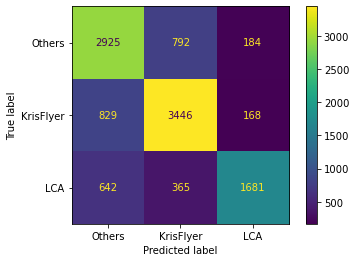

In [98]:
y_pred = NB_model.predict(X_test_cvec)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [99]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support

           0       0.67      0.75      0.71      3901
           1       0.75      0.78      0.76      4443
           2       0.83      0.63      0.71      2688

    accuracy                           0.73     11032
   macro avg       0.75      0.72      0.73     11032
weighted avg       0.74      0.73      0.73     11032



- display the macro average ROC AUC score

In [100]:
y_pred_prob = NB_model.predict_proba(X_test_cvec)

roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')

0.8783042605417539

- display macro average f1-score

In [101]:
f1_score(y_test, y_pred, labels=[1,2], average = 'macro')

0.7370104822802401

## 4.2 Baseline 2 (with Lemm)

- lemmatise both the text and stopwords

In [102]:
lemmer = WordNetLemmatizer()

- function to tokenise, lemm, and join text

In [103]:
def token_lemm(sent):
    result = []
    list = word_tokenize(sent)
    for word in list:
        result.append(lemmer.lemmatize(word))
    return ' '.join(result)

In [104]:
services_lemm_df = services_df.copy()
services_lemm_df['text'] = [token_lemm(text) for text in services_df['text']]
services_lemm_df.head()

,text,source,y_true
0,Qualifying a EG for the first time,kf,1
1,Which FFP for me ? Master Discussion,kf,1
2,# SQMelbourneTram,kf,1
3,Advice sought - Changing redemption booking,kf,1
4,First Savers SYD-SIN,kf,1


In [105]:
lemm_stopwords = [lemmer.lemmatize(word) for word in cvec.get_stop_words()]
print(lemm_stopwords)

['we', 'mine', 'full', 'that', 'must', 'rather', 'next', 'them', 'twenty', 'becomes', 'up', 'across', 'no', 'though', 'cannot', 'perhaps', 'done', 'thereby', 'yet', 'whether', 'sixty', 're', 'then', 'himself', 'themselves', 'here', 'sometimes', 'or', 'everywhere', 'anyone', 'u', 'own', 'towards', 'front', 'ours', 'top', 'anyway', 'nowhere', 'together', 'everything', 'before', 'go', 'nothing', 'onto', 'not', 'either', 'such', 'somewhere', 'seems', 'she', 'bottom', 'ltd', 'and', 'other', 'last', 'le', 'any', 'why', 'found', 'noone', 'hereby', 'throughout', 'an', 'me', 'describe', 'whereas', 'whereafter', 'him', 'amoungst', 'these', 'how', 'wherein', 'now', 'seem', 'fifteen', 'amount', 'moreover', 'made', 'over', 'while', 'nor', 'who', 'cant', 'everyone', 'others', 'his', 'however', 'along', 'whereby', 'meanwhile', 'am', 'sincere', 'almost', 'please', 'fill', 'find', 'can', 'whole', 'although', 'whatever', 'back', 'few', 'very', 'this', 'move', 'whom', 'below', 'much', 'whenever', 'someth

- train-test split

In [106]:
X = services_lemm_df['text']
y = services_lemm_df['y_true']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train

13477    Does KF actually explain the difference in qua...
29195    BKK airport closed : SQ et al Cancel flight 26...
22061    Originally posted by SQ LPPView PostThat 's a ...
6624     Originally posted by GLAM82View PostIs there a...
20643    I would have thought they will use the SKL , s...
                               ...                        
12020    Originally posted by CGKView Post SQ prefers I...
43382    I thought I 'd get your view on this , which i...
1598     Originally posted by florianwagnerView PostSo ...
11541            letter dated 19 March received 28 March .
22264    Sorry to report that a I got to SFO airport fo...
Name: text, Length: 33095, dtype: object

- tokenise with Count Vectoriser

In [107]:
cvec = CountVectorizer(max_features = 500, stop_words = lemm_stopwords)
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

- instantiate and fit a Naive Bayes model

In [108]:
nb = MultinomialNB()
NB_model = ovr(nb).fit(X_train_cvec, y_train)  # using OneVsRestClassifier

- visualise confusion matrix

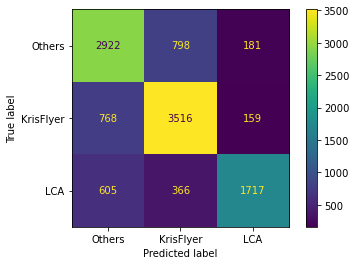

In [109]:
y_pred = NB_model.predict(X_test_cvec)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [110]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support

           0       0.68      0.75      0.71      3901
           1       0.75      0.79      0.77      4443
           2       0.83      0.64      0.72      2688

    accuracy                           0.74     11032
   macro avg       0.76      0.73      0.74     11032
weighted avg       0.75      0.74      0.74     11032



- display the macro average ROC AUC score

In [111]:
y_pred_prob = NB_model.predict_proba(X_test_cvec)

roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')

0.8852325761509331

- display macro average f1-score

In [112]:
f1_score(y_test, y_pred, labels=[1,2], average = 'macro')

0.7472541233975153

## 4.3 Baseline 3 (with Stem)

- stem both the text and stopwords

In [113]:
stemmer = PorterStemmer()

- function to tokenise, stem, join text

In [114]:
def token_stem(sent):
    result = []
    list = word_tokenize(sent)
    for word in list:
        result.append(stemmer.stem(word))
    return ' '.join(result)

In [115]:
services_stem_df = services_df.copy()
services_stem_df['text'] = [token_stem(text) for text in services_df['text']]
services_stem_df.head()

,text,source,y_true
0,qualifi as eg for the first time,kf,1
1,which ffp for me ? master discuss,kf,1
2,# sqmelbournetram,kf,1
3,advic sought - chang redempt book,kf,1
4,first saver syd-sin,kf,1


In [116]:
stem_stopwords = [stemmer.stem(word) for word in cvec.get_stop_words()]
print(stem_stopwords)

['we', 'mine', 'full', 'that', 'must', 'rather', 'next', 'them', 'twenti', 'becom', 'up', 'across', 'no', 'though', 'cannot', 'perhap', 'done', 'therebi', 'yet', 'whether', 'sixti', 're', 'then', 'himself', 'themselv', 'here', 'sometim', 'or', 'everywher', 'anyon', 'own', 'toward', 'front', 'our', 'top', 'nowher', 'togeth', 'anyway', 'everyth', 'befor', 'go', 'noth', 'onto', 'not', 'either', 'such', 'somewher', 'seem', 'she', 'bottom', 'ltd', 'and', 'other', 'last', 'ani', 'whi', 'found', 'noon', 'herebi', 'throughout', 'an', 'me', 'describ', 'wherea', 'whereaft', 'him', 'amoungst', 'these', 'how', 'wherein', 'now', 'seem', 'fifteen', 'amount', 'moreov', 'made', 'over', 'while', 'nor', 'who', 'cant', 'everyon', 'other', 'hi', 'howev', 'along', 'wherebi', 'meanwhil', 'am', 'sincer', 'almost', 'pleas', 'fill', 'find', 'can', 'whole', 'although', 'whatev', 'back', 'few', 'veri', 'thi', 'move', 'le', 'whom', 'below', 'much', 'whenev', 'someth', 'de', 'toward', 'nevertheless', 'thereaft', '

- train-test split

In [117]:
X = services_stem_df['text']
y = services_stem_df['y_true']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train

13477    doe kf actual explain the differ in qualifi da...
29195    bkk airport close : sq et al cancel flight 26 ...
22061    origin post by sq lppview postthat 's a veri g...
6624     origin post by glam82view posti there a better...
20643    i would have thought they will use the skl , s...
                               ...                        
12020    origin post by cgkview post sq prefer i stay i...
43382    i thought i 'd get your view on thi , which is...
1598     origin post by florianwagnerview postso would ...
11541               letter date 19 march receiv 28 march .
22264    sorri to report that as i got to sfo airport f...
Name: text, Length: 33095, dtype: object

- tokenise with Count Vectoriser

In [118]:
cvec = CountVectorizer(max_features = 500, stop_words = stem_stopwords)
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

- instantiate and fit a Naive Bayes model

In [119]:
nb = MultinomialNB()
NB_model = ovr(nb).fit(X_train_cvec, y_train)  # using OneVsRestClassifier

- visualise confusion matrix

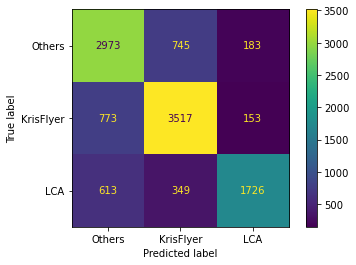

In [120]:
y_pred = NB_model.predict(X_test_cvec)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [121]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support

           0       0.68      0.76      0.72      3901
           1       0.76      0.79      0.78      4443
           2       0.84      0.64      0.73      2688

    accuracy                           0.74     11032
   macro avg       0.76      0.73      0.74     11032
weighted avg       0.75      0.74      0.74     11032



- display the macro average ROC AUC score

In [122]:
y_pred_prob = NB_model.predict_proba(X_test_cvec)

roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')

0.8870457606060408

- display macro average f1-score

In [123]:
f1_score(y_test, y_pred, labels=[1,2], average = 'macro')

0.7518155162591702

---
## 5. Remarks
---

|                        | Baseline 1              | Baseline 2                 | Baseline 3                 |
|------------------------|-------------------------|----------------------------|----------------------------|
| Pre-processing         | Basic cleaning          | - basic cleaning<br>- lemm | - basic cleaning<br>- stem |
| Vectoriser             | CountVectoriser         | CountVectoriser            | CountVectoriser            |
| Model                  | Multinomial Naive Bayes | Multinomial Naive Bayes    | Multinomial Naive Bayes    |
| macro-average ROC AUC  | 0.878                   | 0.885                      | 0.887                      |
| macro-average f1-score | 0.737                   | 0.747                      | 0.752                      |

- Baseline 3 (with stemming) performed the best with the macro-average ROC AUC score of 0.89 and macro-average f1-score of 0.75. This result indicated that our dataset, given the minimal pre-processing and use of a basic vectoriser, is quite clean and that the categories of KrisFlyer, LCA and others are quite distinct from each other.
<br>
<br>
- For this business case, false positive and negative results for predicting both KrisFlyer and LCA-related comments are equally undesirable. Misclassifying these comments (in either direction) is frustrating for customers, and can lead to lower customer satisfaction, higher complaints and may turn the valued customers away towards competitors. 
<br>
<br>
- Hence, the 2 key metrics to optimise for are (1) the macro-average ROC AUC score and (2) the macro-average f1-score of KrisFlyer and LCA classes. Macro metrics are used since the classes were imbalanced. [(source)](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f)